In [159]:
import numpy as np
from rerf.urerf import UnsupervisedRandomForest
import matplotlib.pyplot as plt

from joblib import Parallel, delayed
import seaborn as sns
sns.set()

colors = sns.color_palette("Dark2")

In [188]:
def generate_circle(n, r=5, theta0=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    thetas = np.random.uniform(0, 2*np.math.pi, n-1)
    
    Xs = np.array([np.array([r * np.cos(theta), r * np.sin(theta)]) for theta in thetas])
    X0 = np.array([r*np.cos(theta0), r*np.sin(theta0)])
    Xs = np.concatenate(([X0], Xs))
        
    distances = np.array([min([np.pi * (2*np.pi - (theta - theta0))*r, np.pi* (theta - theta0)*r]) for theta in thetas])
    
    nearest_neighbors_idx = np.argsort(distances)
    
    return Xs, nearest_neighbors_idx


def generate_cube(n, d, x0='origin', acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    if x0 is 'origin':
        x0 = np.zeros(d)
        
    Xs = np.random.uniform(-1,1,size=(n-1,d))
    distances = np.sqrt(np.sum((Xs - x0)**2, axis=1)).reshape((n-1))
    
    Xs = np.concatenate(([x0], Xs))
    nearest_neighbors_idx = np.argsort(distances)
    
    return Xs, nearest_neighbors_idx
    

def get_kprimes(true_nn, rf_nn):
    kprimes = []
    n = len(true_nn) + 1
    for k in range(1, n):
        knn = set(true_nn[:k])

        n_found = 0
        i = 0
        while n_found < k:
            if rf_nn[i] in knn:
                n_found += 1
            i += 1
        kprimes.append(i)
    return np.array(kprimes)
    
def experiment(n, func, mc_its=200, fixed_k=0, n_cores=1, acorn=None, **kwargs):
    if acorn is not None:
        np.random.seed(acorn)
    
    if fixed_k == 0:
        kprimes = np.zeros((mc_its, n-1))
        mean_kprimes = np.zeros(n-1)
        std_kprimes = np.zeros(n-1)
    else:
        kprimes = np.zeros(mc_its)
            
    if n_cores != 1 and fixed_k != 0:
        keys = list(kwargs.keys())
        
        if 'r' in keys:
            r = kwargs['r']
            theta0 = kwargs['theta0']
            condensed_func = lambda x: _experiment_for_loop(x, func, fixed_k, 
                                                            r=r, theta0=theta0)
        else:
            d = kwargs['d']
            x0 = kwargs['x0']
            
            if x0 is 'origin':
                x0 = np.zeros(d)
            
            condensed_func = lambda x: _experiment_for_loop(x, func, fixed_k, 
                                                            d=d, x0=x0)
        kprimes = np.array(Parallel(n_jobs=n_cores)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
        return np.mean(kprimes), np.std(kprimes, ddof=1)
    
    for i in range(mc_its):
        Xs, true_nn = func(n, **kwargs)

        clf = UnsupervisedRandomForest(projection_matrix="RerF")
        clf.fit(Xs)
        W = 1 - clf.transform()
        rf_nn = np.argsort(W[0, 1:])

        if fixed_k == 0:
            kprimes[i] = get_kprimes(true_nn, rf_nn)
        else:
            kprimes[i] = get_kprimes(true_nn, rf_nn)[fixed_k - 1]

    if fixed_k == 0:        
        return np.mean(kprimes, axis=0), np.std(kprimes, ddof=1, axis=0)
    else:
        return np.mean(kprimes), np.std(kprimes, ddof=1)
    
def _experiment_for_loop(n, func, fixed_k=0, acorn=None, **kwargs):
    if acorn is not None:
        np.random.seed(acorn)
            
    Xs, true_nn = func(n, **kwargs)
        
    clf = UnsupervisedRandomForest(projection_matrix="RerF", random_state=0)
    clf.fit(Xs)
    W = 1 - clf.transform()
    rf_nn = np.argsort(W[0, 1:])

    if fixed_k == 0:
        return get_kprimes(true_nn, rf_nn)
    else:
        return get_kprimes(true_nn, rf_nn)[fixed_k - 1]

In [189]:
experiment(200, generate_circle, fixed_k=5, n_cores=-2, **{'r': 5, 'theta0':0})
experiment(200, generate_cube, fixed_k=5, n_cores=-2, **{'d': 3, 'x0':[0,0,0]})

(84.52, 52.386940717978035)

In [3]:
from tqdm import tqdm

ns = np.array([100, 200, 500, 1000, 2000])
mc_its = 100
theta0 = 0
r = 5

means = []
stds = []



for i, n in enumerate(tqdm(ns)):
    temp = experiment(n, r, theta0, mc_its, acorn=i)
    means.append(temp[0])
    stds.append(temp[1])

100%|██████████| 5/5 [08:06<00:00, 132.88s/it]


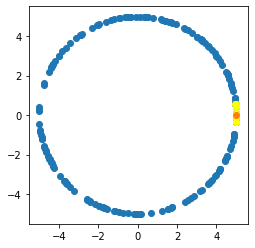

In [10]:
n=200
k=10
Xs, nn = generate_circle(n)

knn = nn[:k]


fig, ax = plt.subplots(1,1)
ax.scatter(Xs[:, 0], Xs[:, 1])
ax.scatter(Xs[1:, :][knn,0], Xs[1:, :][knn,1], c = 'yellow')
ax.scatter(5*np.cos(0), 5*np.sin(0))

ax.set_aspect('equal')
plt.savefig('circle_r5_k10.png')

In [199]:
from tqdm import tqdm

h=250
ns = np.arange(h, 1000+h, step = h)
nmc = (len(ns)+3)* [200]

r=1

ns = np.concatenate((ns, [1250, 1500, 2000, 2500, 3500, 5000]))
nmc = np.concatenate((nmc, 3*[100]))

kwargs_circle = {'r':r, 'theta0':0}

ks = np.array([5, 10, 20])

means_ = [[] for k in ks]
stds_ = [[] for k in ks]
np.random.seed(2)


for j, k in enumerate(tqdm(ks)):
    for i, n in enumerate(ns):
        if k < n:
            temp = experiment(n, mc_its=nmc[i], func=generate_circle, fixed_k=k, n_cores=-2, **kwargs_circle)
            means_[j].append(temp[0])
            stds_[j].append(temp[1])



















  0%|          | 0/3 [00:00<?, ?it/s]

















 33%|███▎      | 1/3 [02:46<05:32, 166.32s/it]

















 67%|██████▋   | 2/3 [05:32<02:46, 166.35s/it]

















100%|██████████| 3/3 [08:19<00:00, 166.58s/it]

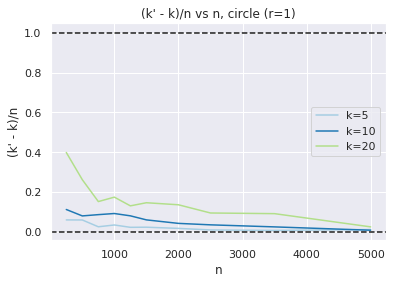

In [200]:
# plotting cell
colors = sns.color_palette("Paired", n_colors=len(ks))
fig, ax = plt.subplots(1,1)

for i, k in enumerate(ks):
    diff = len(ns) - len(means_[i])
    ax.plot(ns[diff:], (np.array(means_[i]) - k)/ns[diff:], label='k=%i'%(k), c=colors[i])
    ax.set_title("(k' - k)/n vs n, circle (r=%i)"%(r))
ax.set_xlabel('n')
ax.set_ylabel("(k' - k)/n")
ax.axhline(y=1, c='k', ls="--")
ax.axhline(y=0, c='k', ls="--")
ax.legend()

plt.savefig('circle_r%i_noup.png'%(r))

In [191]:
from tqdm import tqdm

h=250
ns = np.arange(h, 1000+h, step = h)
nmc = (len(ns)+3)* [200]

ns = np.concatenate((ns, [1250, 1500, 2000, 2500, 3500, 5000]))
nmc = np.concatenate((nmc, 3*[100]))

kwargs_cube = {'d':3, 'x0':'origin'}

ks = np.array([5, 10, 20])

means_cube = [[] for k in ks]
stds_cube = [[] for k in ks]
np.random.seed(2)


for j, k in enumerate(tqdm(ks)):
    for i, n in enumerate(ns):
        if k < n:
            temp = experiment(n, mc_its=nmc[i], func=generate_cube, fixed_k=k, n_cores=-2, **kwargs_cube)
            means_cube[j].append(temp[0])
            stds_cube[j].append(temp[1])














  0%|          | 0/3 [00:00<?, ?it/s]

IndexError: index 19 is out of bounds for axis 0 with size 19

In [ ]:
# plotting cell
colors = sns.color_palette("Paired", n_colors=len(ks))
fig, ax = plt.subplots(1,1)

for i, k in enumerate(ks):
    diff = len(ns) - len(means_cube[i])
    ax.plot(ns[diff:], (np.array(means_cube[i]) - k)/ns[diff:], label='k=%i'%(k), c=colors[i])
    ax.set_title("(k' - k)/n vs n, cube (d=%i)"%(d))
ax.set_xlabel('n')
ax.set_ylabel("(k' - k)/n")
ax.axhline(y=1, c='k', ls="--")
ax.axhline(y=0, c='k', ls="--")
ax.legend()

plt.savefig('cube_d%i_noup.png'%(d))

In [ ]:
#- Graveyard

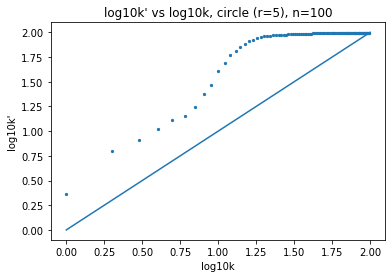

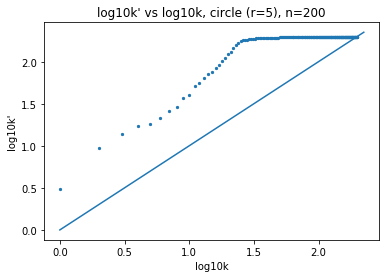

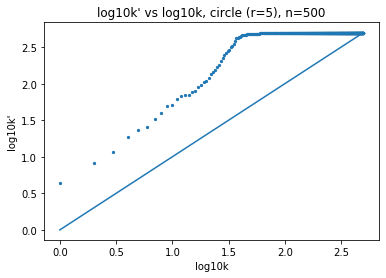

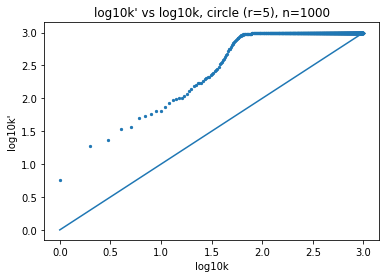

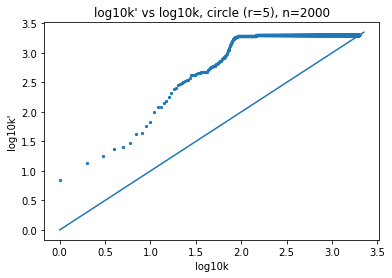

In [36]:
for i, n in enumerate(ns):
    fig, ax = plt.subplots(1,1)
    ax.scatter(np.log10(np.array(range(1, n))), np.log10(means[i]), s = 5)
    ax.set_title("log10k' vs log10k, circle (r=5), n=%i"%(n))
    ax.set_xlabel('log10k')
    ax.set_ylabel("log10k'")
    ax.plot(np.arange(0, np.log10(n) + 0.05, step=0.05), np.arange(0, np.log10(n) + 0.05, step=0.05))
    plt.savefig('circle_r5_loglog_n%i'%(n) + '.png')

In [56]:
from tqdm import tqdm

h=100
ns_ = np.arange(h, 1000+h, step = h)
mc_its = (len(ns_)+3)* [500]

ns_ = np.concatenate((ns_, [1250, 1500, 2000, 2500, 3500, 5000]))
mc_its = np.concatenate((mc_its, 3*[200]))


mc_its_ = 200
theta0_ = 0
r_ = 5

means_ = []
stds_ = []

np.random.seed(2)
for i, n in enumerate(tqdm(ns_)):
    temp = experiment(n, r_, theta0_, mc_its[i], fixed_k=20, n_cores=-2)
    means_.append(temp[0])
    stds_.append(temp[1])









  0%|          | 0/16 [00:00<?, ?it/s]







  6%|▋         | 1/16 [00:02<00:39,  2.65s/it]







 12%|█▎        | 2/16 [00:06<00:42,  3.00s/it]







 19%|█▉        | 3/16 [00:10<00:43,  3.35s/it]







 25%|██▌       | 4/16 [00:15<00:44,  3.75s/it]







 31%|███▏      | 5/16 [00:21<00:48,  4.38s/it]







 38%|███▊      | 6/16 [00:28<00:52,  5.29s/it]







 44%|████▍     | 7/16 [00:37<00:58,  6.47s/it]







 50%|█████     | 8/16 [00:48<01:02,  7.82s/it]







 56%|█████▋    | 9/16 [01:02<01:06,  9.48s/it]







 62%|██████▎   | 10/16 [01:17<01:07, 11.28s/it]







 69%|██████▉   | 11/16 [01:39<01:12, 14.49s/it]







 75%|███████▌  | 12/16 [02:09<01:15, 18.97s/it]







 81%|████████▏ | 13/16 [02:56<01:22, 27.56s/it]







 88%|████████▊ | 14/16 [03:26<00:56, 28.40s/it]







 94%|█████████▍| 15/16 [04:21<00:36, 36.32s/it]







100%|██████████| 16/16 [06:06<00:00, 56.98s/it]

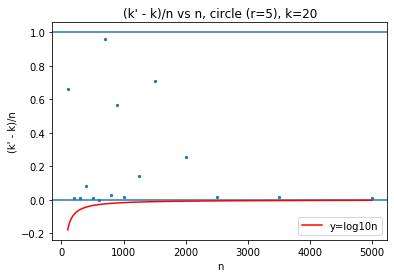

In [58]:
fig, ax = plt.subplots(1,1)
ax.scatter(ns_, (np.array(means_) - 20)/ns_, s = 5)
ax.set_title("(k' - k)/n vs n, circle (r=5), k=%i"%(20))
ax.set_xlabel('n')
ax.set_ylabel("(k' - k)/n")
ax.axhline(y=1)
ax.axhline(y=0)
# ax.plot(np.arange(1, n, step=0.05), np.arange(1, n, step=0.05), label='y=n')
ax.plot(np.arange(100, n, step=0.05), (np.log10(np.arange(100, n, step=0.05)) - 20) / np.arange(100, n, step=0.05), c='r', label='y=log10n')
# plt.errorbar(ns_, (np.array(means_) - 20) / ns_, yerr=1.96*np.array(stds_)/np.sqrt(mc_its_),alpha=0.15)
ax.legend()

plt.savefig('circle_r5_k20' + '.png')

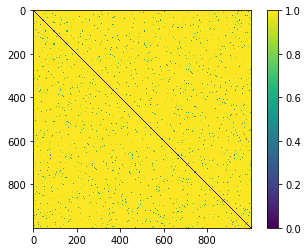

In [109]:
clf = UnsupervisedRandomForest(projection_matrix="RerF", random_state=0)
clf.fit(Xs)
W = 1 - clf.transform()
plt.imshow(W)
plt.colorbar()

In [110]:
rf_nn = np.argsort(W[0, 1:])

k_primes = []
for k in range(n - 1):
    knn = set(nn[:k])
    
    n_found = 0
    i = 0
    while n_found < k:
        if rf_nn[i] in knn:
            n_found += 1
        i += 1
    k_primes.append(i)

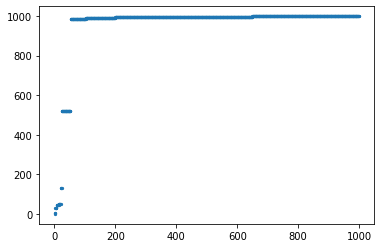

In [113]:
fig, ax = plt.subplots(1,1)
ax.scatter(range(1, n), k_primes, s = 5)
# ax.plot(np.arange(1, n), np.arange(1, n) + np.log(n))

[0.86567091 0.64605139 1.06653785 0.69988245 0.80501973 0.93867621
 0.82299917 1.01871907 0.42345931 1.20136147 1.23140573 0.82636276
 1.14469193 1.42142214 0.58595043 0.93583762 1.44377815 1.17127311
 1.1359434  1.43907513 1.11958495 1.00003894 0.83492577 0.88645956
 1.15818986 0.88346351 1.05663574 0.93788097 0.7906714  1.29747908
 1.20488983 1.06955708 1.15319017 1.0062621  0.88613696 0.82721945
 0.80653744 0.42042345 0.47325391 0.62876618 1.07942602 0.95164859
 1.04836685 0.92052288 1.11562232 0.65361143 1.07894282 1.20009406
 1.09570266 1.04630252 0.60067961 0.84989512 0.76522193 0.25837015
 0.92049378 0.96980324 0.87244393 1.10792957 1.1859922  0.79878865
 1.17471567 1.16262608 1.39389983 1.27958699 1.1030699  1.02116588
 0.78057187 1.05166648 0.57999387 1.05995473 0.81360706 1.06315154
 0.77111104 1.31126916 0.70335214 1.1623697  0.60164778 1.47251522
 1.21676186 0.44733871 0.65975941 1.0840172  1.1156411  1.08574257
 0.77138956 0.52601734 0.84269197 0.5351249  1.22359285 0.3197

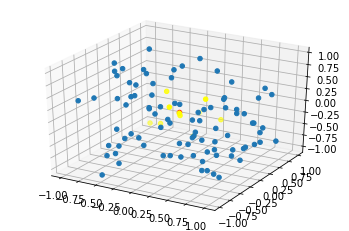

In [90]:
Xs_cube, nn_cube = generate_cube(100, d=3)

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xs_cube[1:][nn_cube[10:],0], Xs_cube[1:][nn_cube[10:],1], Xs_cube[1:][nn_cube[10:],2],alpha=1)
ax.scatter(0,0,0, c='r')
ax.scatter(Xs_cube[1:][nn_cube[:10],0], Xs_cube[1:][nn_cube[:10],1], Xs_cube[1:][nn_cube[:10],2], c='yellow')

plt.savefig('3d_cube.png', dpi=500)

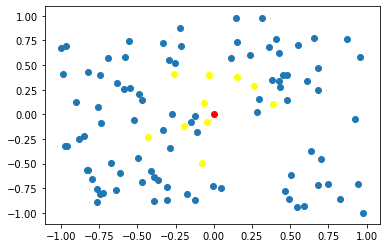

In [87]:
fig, ax = plt.subplots(1,1)
ax.scatter(Xs_cube[1:][nn_cube[10:],0], Xs_cube[1:][nn_cube[10:],1],alpha=1)
ax.scatter(0,0, c='r')
ax.scatter(Xs_cube[1:][nn_cube[:10],0], Xs_cube[1:][nn_cube[:10],1], c='yellow')

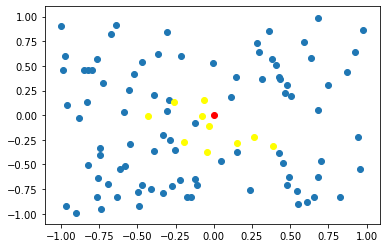

In [88]:
fig, ax = plt.subplots(1,1)
ax.scatter(Xs_cube[1:][nn_cube[10:],0], Xs_cube[1:][nn_cube[10:],2],alpha=1)
ax.scatter(0,0, c='r')
ax.scatter(Xs_cube[1:][nn_cube[:10],0], Xs_cube[1:][nn_cube[:10],2], c='yellow')

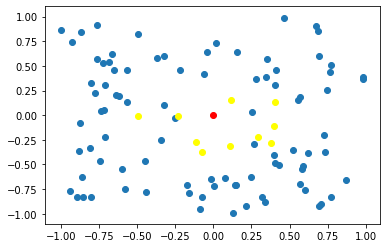

In [89]:
fig, ax = plt.subplots(1,1)
ax.scatter(Xs_cube[1:][nn_cube[10:],1], Xs_cube[1:][nn_cube[10:],2],alpha=1)
ax.scatter(0,0, c='r')
ax.scatter(Xs_cube[1:][nn_cube[:10],1], Xs_cube[1:][nn_cube[:10],2], c='yellow')